In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle
import time
import nltk
import keras.backend as K

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model 
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, concatenate
from tensorflow.keras import losses, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


# training parameters
embedding_dim = 150
lstm_dim = 50
lstm_dropout = 0.1

In [19]:
# !pip install --user albumentations


In [2]:
# import os
# import cv2
# import albumentations as A

# # Source and destination folders
# source_folder = r'C:\Users\HP\Desktop\Dataset\Aug2'
# destination_folder = r'C:\Users\HP\Desktop\Dataset\Format2'

# # Ensure destination folder exists
# os.makedirs(destination_folder, exist_ok=True)

# # Define augmentation pipeline
# transform = A.Compose([
#     #A.RandomCrop(width=224, height=224),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
#     A.Rotate(limit=30, p=0.5),
# ])

# # Iterate through images in source folder
# for filename in os.listdir(source_folder):
#     if filename.endswith((".jpeg", ".jpg", ".png", ".JPEG", ".JPG", ".PNG")):  # Check if the file is an image
#         # Load image
#         image = cv2.imread(os.path.join(source_folder, filename))
#         # Apply augmentation
#         augmented = transform(image=image)
#         augmented_image = augmented["image"]
#         # Save augmented image to destination folder
#         cv2.imwrite(os.path.join(destination_folder, filename), augmented_image)
        
#         # Apply augmentation with rotation at 90 degrees
#         augmented_90 = transform(image=image)
#         augmented_image_90 = augmented_90["image"]
#         augmented_image_90 = cv2.rotate(augmented_image_90, cv2.ROTATE_90_CLOCKWISE)
#         # Save augmented image to destination folder
#         cv2.imwrite(os.path.join(destination_folder, filename), augmented_image_90)
        
# print("Augmentation completed!")


In [8]:
import os
from PIL import Image
import pandas as pd
import cv2
import numpy as np

images_folder = r'C:\Users\HP\Desktop\Dataset\NEW DATASET'

captions_file = r'C:\Users\HP\Desktop\Dataset\MY TRAINING CAPTIONS1.csv'

captions_df = pd.read_csv(captions_file)

images = []
for filename in captions_df ['IMAGE FILENAME']:
    img_path = os.path.join(images_folder, filename.strip())  # Construct full path
    if not os.path.exists(img_path):
        # If not found, try to find the file with a different case
        base, ext = os.path.splitext(filename)
        possible_extensions = [".jpeg", ".jpg", ".png", ".JPEG", ".JPG", ".PNG"]
        for alt_ext in possible_extensions:
            alt_path = os.path.join(images_folder, f"{base}{alt_ext}")
            if os.path.exists(alt_path):
                image_path = alt_path
                break
    img = Image.open(img_path)
    
    # If the image has an alpha channel, convert it to RGB
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    img_array = np.asarray(img.resize((224, 224), Image.ANTIALIAS))
    
    if len(img_array.shape) == 2:  # Grayscale image
        img_array = np.expand_dims(img_array, axis=-1)  # Add color channel dimension
    
    if img_array.shape[-1] == 1:  # Check for grayscale image
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)  # Convert to RGB

    print(img_array.shape)
    images.append(img_array)

images = np.array(images)  # Convert list to NumPy array
captions = [caption.split() for caption in captions_df['CAPTIONS']]  # Split captions into lists of words


C:\Users\HP\AppData\Local\Temp\ipykernel_2000\2444601816.py:30: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_array = np.asarray(img.resize((224, 224), Image.ANTIALIAS))


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 

In [9]:
print('images: {} {} {}'.format(images.shape, type(images), images.dtype))
print('captions: {} {}'.format(len(captions), type(captions)))


images: (5000, 224, 224, 3) <class 'numpy.ndarray'> uint8
captions: 5000 <class 'list'>


In [10]:
def get_image_codes(images):      
  convnet = MobileNetV2(input_shape=(224,224,3), 
                          include_top=False, 
                          weights='imagenet')

  # Use the 'Conv_1' layer from MobileNetV2 to generate neural codes for each image in the array images
  inpt = convnet.input
  output = convnet.get_layer("Conv_1").output
  conv_1 = K.function([inpt],[output])
  
  image_codes=np.empty((5000,62720), dtype=np.float32)
  for i in range(50):
    neural_codes = conv_1(images[100*i: 100*(i+1)])[0]
    for k in range(50):
      image_codes[i*100+k]=neural_codes[k].flatten()
  return image_codes

image_codes = get_image_codes(images)
print(image_codes.shape)



(5000, 62720)


In [11]:
max_caption_length = 0
word_dict = {}

for caption in captions:  # Assuming 'captions' is a list of lists
    # Update max_caption_length
    max_caption_length = max(max_caption_length, len(caption))
    
    # Process each word in the caption
    for word in caption:
        if word not in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] += 1

# Build word-to-index and index-to-word dictionaries
word_to_idx = {"_": 0}  # Initialize with the special word '_'
idx_to_word = {0: "_"}
idx = 1

# Sort words by frequency in descending order
for k, v in sorted(word_dict.items(), key=lambda item: item[1], reverse=True):
    word_to_idx[k] = idx
    idx_to_word[idx] = k
    idx += 1

# Add the special word '_' to the word_dict
word_dict["_"] = 5000  # Assuming 3000 captions
num_words = len(word_dict)
# Print lengths for verification
print(len(word_dict))
print(len(word_to_idx))
print(len(idx_to_word))
print(max_caption_length)


281
281
281
95


In [12]:
# val_images = images[0:750, ...]
# val_codes = image_codes[0:750, ...]
# val_captions = [captions[k] for k in range(750)]

# test_images = images[750:1500, ...]
# test_codes = image_codes[750:1500, ...]
# test_captions = [captions[k] for k in range(750,1500)]

# train_images = images[1500:, ...]
# train_codes = image_codes[1500:, ...]
# train_captions = [captions[k] for k in range(1500, images.shape[0])]

In [13]:
val_images = images[0:300, ...]
val_codes = image_codes[0:300, ...]
val_captions = [captions[k] for k in range(300)]

test_images = images[300:500, ...]
test_codes = image_codes[300:500, ...]
test_captions = [captions[k] for k in range(300,500)]

train_images = images[500:, ...]
train_codes = image_codes[500:, ...]
train_captions = [captions[k] for k in range(500, images.shape[0])]

In [14]:
import numpy as np

def convert_data(codes, captions, max_caption_length, word_to_idx):
    if codes.shape[0] != len(captions):
        raise AssertionError("Different number of codes and captions.")

    N = codes.shape[0]
    labels = np.zeros((N, max_caption_length), dtype=np.uint32)

    for l in range(N):
        count = 0  # Initialize count to zero
        for w in captions[l]:
            if count < max_caption_length:  # Check if count is within bounds
                labels[l, count] = word_to_idx.get(w, 0)
                count += 1

    return codes, labels

# Assuming train_codes and train_captions are defined earlier in your code
train_codes, train_y = convert_data(train_codes, train_captions, max_caption_length, word_to_idx)
val_codes, val_y = convert_data(val_codes, val_captions, max_caption_length, word_to_idx)

print(train_codes.shape)
print(train_y.shape)
print(val_codes.shape)
print(val_y.shape)

(4500, 62720)
(4500, 95)
(300, 62720)
(300, 95)


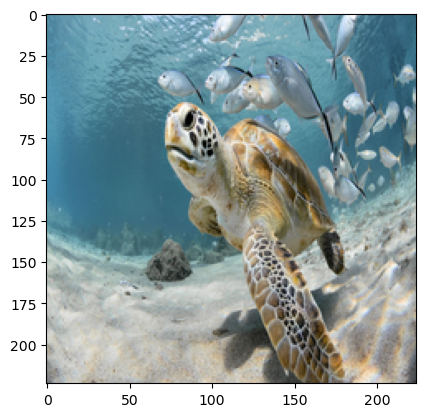

Turtles, part of the reptilian class Reptilia and order Testudines, inhabit diverse environments from oceans and rivers to forests and deserts. Threatened by habitat destruction and illegal trade, some species boast lifespans exceeding a century. Reproducing by laying eggs on land, turtles exhibit varying nesting habits. Once laid, the eggs undergo a Do-It-Yourself journey as turtles typically don't nurture their young. Generally harmless to humans, they tend to retreat into their shells rather than pose a threat. Turtles display diverse diets some herbivores, others omnivores or carnivores. _ _ _ _ _ _ _ _





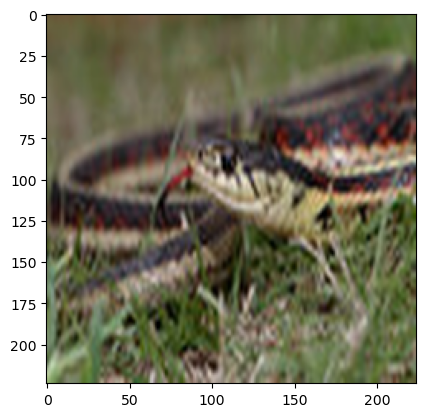

Snakes belong to the class Reptilia and the order Serpentes. Their genus can vary based on the species, so there's a wide variety. Snakes are quite diverse in habitat, ranging from deserts and grasslands to forests and water bodies. Some are endangered due to habitat loss, while others are more adaptable. Snakes are usually on their own from birth, fending for themselves. While many snakes are harmless, some are venomous. However, most snakes would rather avoid humans than engage with them. Snakes have a carnivorous diet, feasting on rodents, birds, eggs, and sometimes other snakes.





In [15]:
def show_random_image_and_captions(images, labels, idx_to_word):
    n = images.shape[0]
    idx = np.random.randint(0, n)

    plt.imshow(images[idx % images.shape[0], ...])
    plt.show()

    encoded_caption = labels[idx, ...]
    encoded_caption = [k for k in encoded_caption if k >= 0]

    caption = [idx_to_word[i] for i in encoded_caption]
    print(" ".join(caption))  # Join the words into a single string
    print("\n\n")

# Assuming idx_to_word is a dictionary
idx_to_word = {i: word for word, i in word_to_idx.items()}

show_random_image_and_captions(train_images, train_y, idx_to_word)
show_random_image_and_captions(val_images, val_y, idx_to_word)


In [16]:
def make_model(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout):

  # inputs
  image_input = Input(shape=(code_length,))
  caption_input = Input(shape=(max_caption_length -1,))
  #caption_input = Input(shape=(max_caption_length,))

  Image_embedding = Dense(embedding_dim, input_shape=(code_length,), activation="relu")
  Image_embedding = Image_embedding(image_input)
  Image_embedding = K.reshape(Image_embedding, shape=(-1,1,150))

  #maps (num_words) different words in a caption with size (max_caption_length) to a vector of dimension (embedding_dim)
  Caption_embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_caption_length)
  Caption_embedding = Caption_embedding(caption_input)
  #concatenate the results and get the lstm output
  Embeddings = concatenate([Image_embedding, Caption_embedding],axis=1)
  lstm = LSTM(lstm_dim, dropout=lstm_dropout, return_sequences=True)
  lstm = lstm(Embeddings)

  output = Dense(num_words,activation="softmax")
  output = output(lstm)

  return Model([image_input, caption_input], output)

model = make_model(code_length=train_codes.shape[1], 
                   max_caption_length=max_caption_length, 
                   embedding_dim=embedding_dim, 
                   num_words=num_words, 
                   lstm_dim=lstm_dim, 
                   lstm_dropout=lstm_dropout)

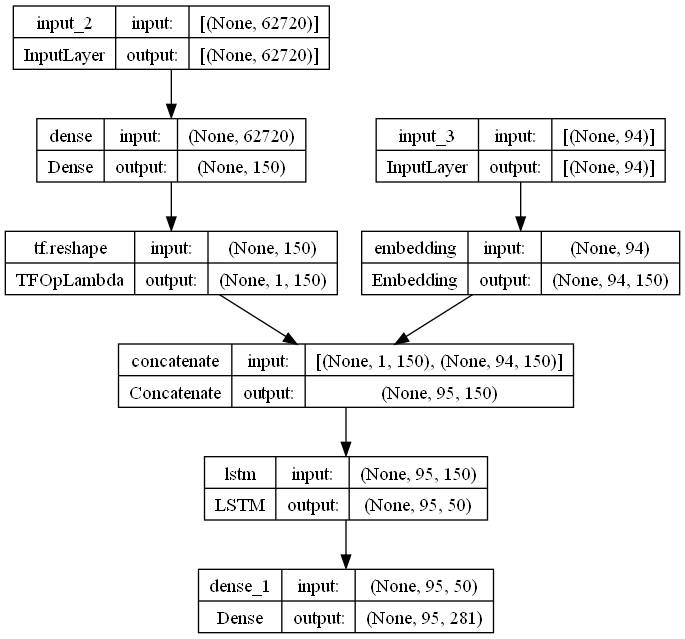

In [17]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'  # Replace this path with the location where Graphviz is installed on your machine

# Now try to import pydot
import pydot

early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=1, mode='auto')

Adam = optimizers.Adam(learning_rate=0.001)
Crossentropy = losses.sparse_categorical_crossentropy
model.compile(optimizer=Adam, loss=Crossentropy)
plot_model(model, show_shapes=True) 

In [ ]:
for i in range(max_caption_length):
  train_cap = np.delete(train_y,i,axis=1)
  val_cap = np.delete(val_y,i,axis=1)
  print("Training word " +str(i+1))
  model.compile(optimizer=Adam, loss=Crossentropy, metrics=['accuracy'])
  model.fit(x=[train_codes,train_cap], y=train_y, batch_size=20,callbacks=[early_stopping_callback], validation_data=([val_codes, val_cap],val_y), epochs=15)
  print("\n")


Training word 1
Epoch 1/15


225/225 [==============================] - 51s 164ms/step - loss: 3.6456 - accuracy: 0.3008 - val_loss: 1.5254 - val_accuracy: 0.8652
Epoch 2/15
225/225 [==============================] - 36s 158ms/step - loss: 0.6707 - accuracy: 0.9773 - val_loss: 0.2218 - val_accuracy: 0.9916
Epoch 3/15
225/225 [==============================] - 36s 159ms/step - loss: 0.1328 - accuracy: 0.9912 - val_loss: 0.0754 - val_accuracy: 0.9913
Epoch 4/15
225/225 [==============================] - 35s 157ms/step - loss: 0.0604 - accuracy: 0.9917 - val_loss: 0.0451 - val_accuracy: 0.9914
Epoch 5/15
225/225 [==============================] - 36s 158ms/step - loss: 0.0404 - accuracy: 0.9916 - val_loss: 0.0339 - val_accuracy: 0.9914
Epoch 6/15
225/225 [==============================] - 36s 160ms/step - loss: 0.0319 - accuracy: 0.9918 - val_loss: 0.0283 - val_accuracy: 0.9914
Epoch 7/15
225/225 [==============================] - 36s 159ms/step - loss: 0.0275 - accuracy: 0.9917 - val_los

In [13]:
model.save(os.path.join(images_folder, 'model.h5'))
#model = load_model(os.path.join(img_path, 'model.h5'))
model = load_model(os.path.join(images_folder, 'model.h5'))
model.summary()

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 62720)]              0         []                            
                                                                                                  
 dense (Dense)               (None, 200)                  1254420   ['input_2[0][0]']             
                                                          0                                       
                                                                                                  
 input_3 (InputLayer)        [(None, 94)]                 0         []                            
                                                                                                  
 tf.reshape (TFOpLambda)     (None, 1, 200)               0         ['dense[0][0]']         

In [24]:
def make_decoder(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout, weights):
  
  # input
  image_input = Input(shape=(code_length,))

  #layers
  Image_embedding = Dense(embedding_dim, input_shape=(code_length,), activation="relu")
  Caption_embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_caption_length)
  lstm = LSTM(lstm_dim, dropout=lstm_dropout, return_sequences=False, return_state=True)
  output = Dense(num_words,activation="softmax")

  embedding = Image_embedding(image_input)
  embedding = K.reshape(embedding, shape=(-1,1,150))
  
  lstm_embedding, state_hidden, state_cell = lstm(embedding)

  word = output(lstm_embedding)
  word = K.argmax(word)
  text = [word]

  for i in range(1,max_caption_length):
    embedding = Caption_embedding(word)
    embedding = K.reshape(embedding, shape=(-1,1,150))
    lstm_embedding, state_hidden, state_cell = lstm(embedding, initial_state=[state_hidden, state_cell])
    word = output(lstm_embedding)
    word = K.argmax(word)
    text.append(word)

    Image_embedding.set_weights(weights[:2])
    Caption_embedding.set_weights([weights[2]])
    lstm.set_weights(weights[3:6])
    output.set_weights(weights[6:])
    
    
  return Model(image_input, text)

# Get the weights from trained model, and put them in a list 'weights'.
# ...
weights = model.get_weights()

decoder = make_decoder(code_length=train_codes.shape[1], 
                       max_caption_length=max_caption_length,
                       embedding_dim=embedding_dim,
                       num_words=num_words, 
                       lstm_dim=lstm_dim, 
                       lstm_dropout=lstm_dropout,
                       weights=weights)

In [26]:
optimizer = optimizers.Adam(lr=0.001)
decoder.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set these parameters to change the data that is used for evaluation
input_data = test_codes
input_images = test_images
input_captions = test_captions

preds = np.array(decoder.predict(input_data))
preds = np.reshape(preds, (max_caption_length, input_data.shape[0]))
preds = np.transpose(preds)

24/24 [==============================] - 54s 139ms/step


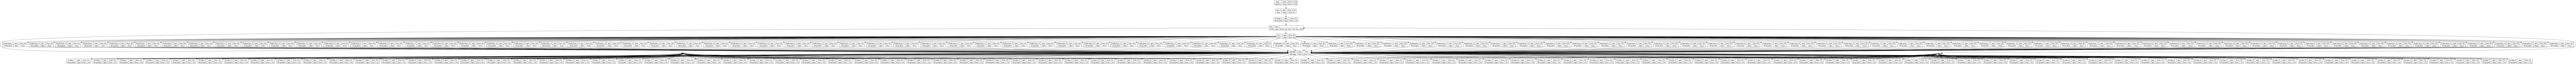

In [28]:
decoder.compile(optimizer=Adam, loss="categorical_crossentropy")
plot_model(decoder, show_shapes=True)

In [17]:
# Save model architecture to JSON file
model_json = decoder.to_json()
with open("decoder_model.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to HDF5 file
decoder.save_weights("decoder_model_weights.h5")


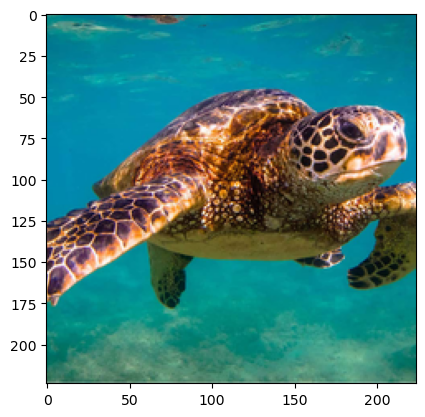

['Turtles,', 'part', 'of', 'the', 'reptilian', 'class', 'Reptilia', 'and', 'order', 'Testudines,', 'inhabit', 'diverse', 'environments', 'from', 'oceans', 'and', 'rivers', 'to', 'forests', 'and', 'deserts.', 'Threatened', 'by', 'habitat', 'destruction', 'and', 'illegal', 'trade,', 'some', 'species', 'boast', 'lifespans', 'exceeding', 'a', 'century.', 'Reproducing', 'by', 'laying', 'eggs', 'on', 'land,', 'turtles', 'exhibit', 'varying', 'nesting', 'habits.', 'Once', 'laid,', 'the', 'eggs', 'undergo', 'a', 'Do-It-Yourself', 'journey', 'as', 'turtles', 'typically', "don't", 'nurture', 'their', 'young.', 'Generally', 'harmless', 'to', 'humans,', 'they', 'tend', 'to', 'retreat', 'into', 'their', 'shells', 'rather', 'than', 'pose', 'a', 'threat.', 'Turtles', 'display', 'diverse', 'diets', 'some', 'herbivores,', 'others', 'omnivores', 'or', 'carnivores.']





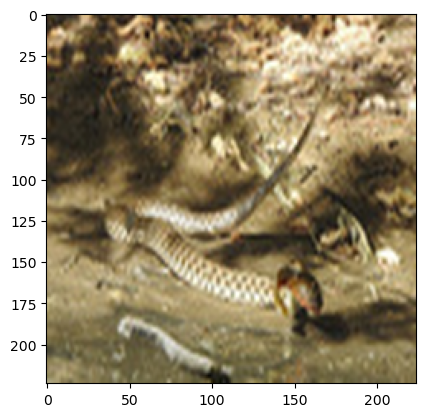

['Snakes', 'belong', 'to', 'the', 'class', 'Reptilia', 'and', 'the', 'order', 'Serpentes.', 'Their', 'genus', 'can', 'vary', 'based', 'on', 'the', 'species,', 'so', "there's", 'a', 'wide', 'variety.', 'Snakes', 'are', 'quite', 'diverse', 'in', 'habitat,', 'ranging', 'from', 'deserts', 'and', 'grasslands', 'to', 'forests', 'and', 'water', 'bodies.', 'Some', 'are', 'endangered', 'due', 'to', 'habitat', 'loss,', 'while', 'others', 'are', 'more', 'adaptable.', 'Snakes', 'are', 'usually', 'on', 'their', 'own', 'from', 'birth,', 'fending', 'for', 'themselves.', 'While', 'many', 'snakes', 'are', 'harmless,', 'some', 'are', 'venomous.', 'However,', 'most', 'snakes', 'would', 'rather', 'avoid', 'humans', 'than', 'engage', 'with', 'them.', 'Snakes', 'have', 'a', 'carnivorous', 'diet,', 'feasting', 'on', 'rodents,', 'birds,', 'eggs,', 'and', 'sometimes', 'other', 'snakes.']





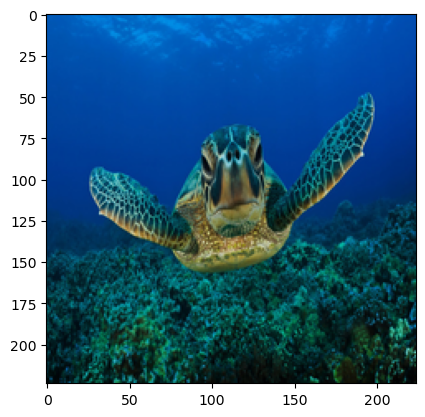

['Domestic', 'cats,', 'like', 'their', 'wild', 'relatives', '(Mammalia,', 'genus', 'Felis),', 'thrive', 'in', 'our', 'homes,', 'living', 'around', '12-15', 'years', 'with', 'proper', 'care.', 'They', 'commonly', 'inhabit', 'living', 'spaces,', 'are', 'not', 'endangered,', 'and', 'have', 'diverse', 'breeds', 'like', 'Domestic', 'Shorthair,', 'Siamese,', 'Persian,', 'Maine', 'Coon,', 'Sphynx,', 'and', 'Bengal.', 'Cats', 'start', 'having', 'kittens', 'at', 'six', 'months,', 'and', 'the', 'mother', 'cares', 'for', 'them', 'until', "they're", 'weaned.', 'Despite', 'occasional', 'furniture', 'scratches,', 'their', 'bond', 'with', 'humans', 'is', 'strong,', 'blending', 'mystery', 'with', 'affection.', 'Their', 'diet', 'primarily', 'revolves', 'around', 'protein.']





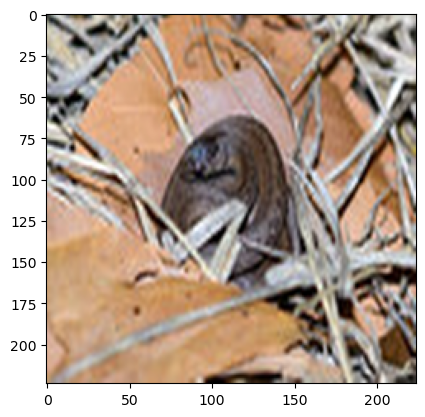

['Snakes', 'belong', 'to', 'the', 'class', 'Reptilia', 'and', 'the', 'order', 'Serpentes.', 'Their', 'genus', 'can', 'vary', 'based', 'on', 'the', 'species,', 'so', "there's", 'a', 'wide', 'variety.', 'Snakes', 'are', 'quite', 'diverse', 'in', 'habitat,', 'ranging', 'from', 'deserts', 'and', 'grasslands', 'to', 'forests', 'and', 'water', 'bodies.', 'Some', 'are', 'endangered', 'due', 'to', 'habitat', 'loss,', 'while', 'others', 'are', 'more', 'adaptable.', 'Snakes', 'are', 'usually', 'on', 'their', 'own', 'from', 'birth,', 'fending', 'for', 'themselves.', 'While', 'many', 'snakes', 'are', 'harmless,', 'some', 'are', 'venomous.', 'However,', 'most', 'snakes', 'would', 'rather', 'avoid', 'humans', 'than', 'engage', 'with', 'them.', 'Snakes', 'have', 'a', 'carnivorous', 'diet,', 'feasting', 'on', 'rodents,', 'birds,', 'eggs,', 'and', 'sometimes', 'other', 'snakes.']





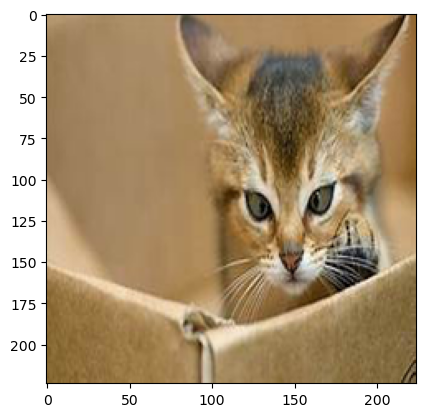

['Domestic', 'cats,', 'like', 'their', 'wild', 'relatives', '(Mammalia,', 'genus', 'Felis),', 'thrive', 'in', 'our', 'homes,', 'living', 'around', '12-15', 'years', 'with', 'proper', 'care.', 'They', 'commonly', 'inhabit', 'living', 'spaces,', 'are', 'not', 'endangered,', 'and', 'have', 'diverse', 'breeds', 'like', 'Domestic', 'Shorthair,', 'Siamese,', 'Persian,', 'Maine', 'Coon,', 'Sphynx,', 'and', 'Bengal.', 'Cats', 'start', 'having', 'kittens', 'at', 'six', 'months,', 'and', 'the', 'mother', 'cares', 'for', 'them', 'until', "they're", 'weaned.', 'Despite', 'occasional', 'furniture', 'scratches,', 'their', 'bond', 'with', 'humans', 'is', 'strong,', 'blending', 'mystery', 'with', 'affection.', 'Their', 'diet', 'primarily', 'revolves', 'around', 'protein.']





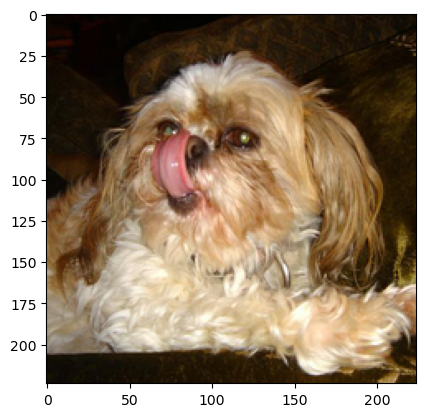

['Dogs', 'are', 'of', 'the', 'class', 'Mammalia', 'and', 'genus', 'Canis', 'and', 'are', 'adaptable', 'from', 'home', 'to', 'outdoors.', 'Dog', 'species', 'are', 'not', 'endangered', 'and', 'they', 'have', 'a', 'life', 'span', 'of', '10-13', 'year', 'lifespan,', 'varying', 'by', 'breed.', 'Dogs', 'give', 'birth', 'to', 'litters', 'varying', 'between', '6', 'to', '10.', 'Although', 'dogs', 'are', 'known', 'for', 'friendliness', 'and', 'unmatched', 'loyalty,', 'there', 'are', 'yet', 'harmful', 'breeds', 'that', 'one', 'should', 'be', 'careful', 'of.', 'Naturally', 'dogs', 'are', 'for', 'security', 'purpose', 'so', 'before', 'you', 'step', 'on', 'that', 'lawn,', 'before', 'you', 'open', 'that', 'gate,', 'watch', 'out.', 'Dogs', 'are', 'omnivores', 'as', 'they', 'have', 'diverse', 'diets.']





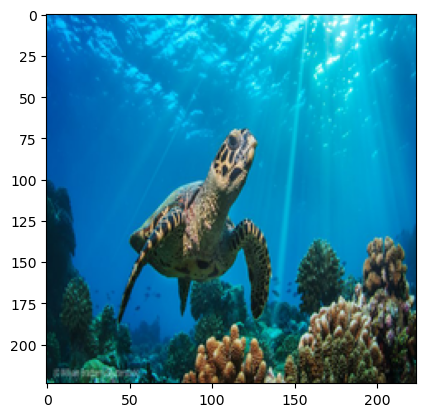

['Turtles,', 'part', 'of', 'the', 'reptilian', 'class', 'Reptilia', 'and', 'order', 'Testudines,', 'inhabit', 'diverse', 'environments', 'from', 'oceans', 'and', 'rivers', 'to', 'forests', 'and', 'deserts.', 'Threatened', 'by', 'habitat', 'destruction', 'and', 'illegal', 'trade,', 'some', 'species', 'boast', 'lifespans', 'exceeding', 'a', 'century.', 'Reproducing', 'by', 'laying', 'eggs', 'on', 'land,', 'turtles', 'exhibit', 'varying', 'nesting', 'habits.', 'Once', 'laid,', 'the', 'eggs', 'undergo', 'a', 'Do-It-Yourself', 'journey', 'as', 'turtles', 'typically', "don't", 'nurture', 'their', 'young.', 'Generally', 'harmless', 'to', 'humans,', 'they', 'tend', 'to', 'retreat', 'into', 'their', 'shells', 'rather', 'than', 'pose', 'a', 'threat.', 'Turtles', 'display', 'diverse', 'diets', 'some', 'herbivores,', 'others', 'omnivores', 'or', 'carnivores.']





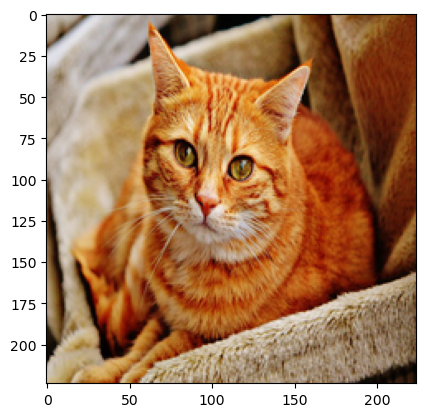

['Domestic', 'cats,', 'like', 'their', 'wild', 'relatives', '(Mammalia,', 'genus', 'Felis),', 'thrive', 'in', 'our', 'homes,', 'living', 'around', '12-15', 'years', 'with', 'proper', 'care.', 'They', 'commonly', 'inhabit', 'living', 'spaces,', 'are', 'not', 'endangered,', 'and', 'have', 'diverse', 'breeds', 'like', 'Domestic', 'Shorthair,', 'Siamese,', 'Persian,', 'Maine', 'Coon,', 'Sphynx,', 'and', 'Bengal.', 'Cats', 'start', 'having', 'kittens', 'at', 'six', 'months,', 'and', 'the', 'mother', 'cares', 'for', 'them', 'until', "they're", 'weaned.', 'Despite', 'occasional', 'furniture', 'scratches,', 'their', 'bond', 'with', 'humans', 'is', 'strong,', 'blending', 'mystery', 'with', 'affection.', 'Their', 'diet', 'primarily', 'revolves', 'around', 'protein.']





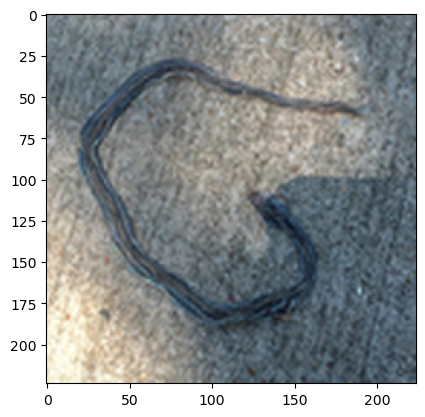

['Domestic', 'cats,', 'like', 'their', 'wild', 'relatives', '(Mammalia,', 'genus', 'Felis),', 'thrive', 'in', 'our', 'homes,', 'living', 'around', '12-15', 'years', 'with', 'proper', 'care.', 'They', 'commonly', 'inhabit', 'living', 'spaces,', 'are', 'not', 'endangered,', 'and', 'have', 'diverse', 'breeds', 'like', 'Domestic', 'Shorthair,', 'Siamese,', 'Persian,', 'Maine', 'Coon,', 'Sphynx,', 'and', 'Bengal.', 'Cats', 'start', 'having', 'kittens', 'at', 'six', 'months,', 'and', 'the', 'mother', 'cares', 'for', 'them', 'until', "they're", 'weaned.', 'Despite', 'occasional', 'furniture', 'scratches,', 'their', 'bond', 'with', 'humans', 'is', 'strong,', 'blending', 'mystery', 'with', 'affection.', 'Their', 'diet', 'primarily', 'revolves', 'around', 'protein.']





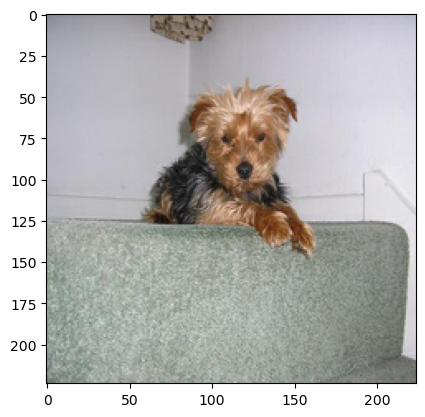

['Domestic', 'cats,', 'like', 'their', 'wild', 'relatives', '(Mammalia,', 'genus', 'Felis),', 'thrive', 'in', 'our', 'homes,', 'living', 'around', '12-15', 'years', 'with', 'proper', 'care.', 'They', 'commonly', 'inhabit', 'living', 'spaces,', 'are', 'not', 'endangered,', 'and', 'have', 'diverse', 'breeds', 'like', 'Domestic', 'Shorthair,', 'Siamese,', 'Persian,', 'Maine', 'Coon,', 'Sphynx,', 'and', 'Bengal.', 'Cats', 'start', 'having', 'kittens', 'at', 'six', 'months,', 'and', 'the', 'mother', 'cares', 'for', 'them', 'until', "they're", 'weaned.', 'Despite', 'occasional', 'furniture', 'scratches,', 'their', 'bond', 'with', 'humans', 'is', 'strong,', 'blending', 'mystery', 'with', 'affection.', 'Their', 'diet', 'primarily', 'revolves', 'around', 'protein.']





In [18]:
test_codes, test_y = convert_data(test_codes, test_captions, max_caption_length, word_to_idx)

#train_codes, train_y = convert_data(train_codes, train_captions, max_caption_length, word_to_idx)
def random_image(images, codes ,labels, idx_to_word):
  for k in range(10):
    n = images.shape[0]
    idx = np.random.randint(0, n)
    plt.imshow(images[idx % images.shape[0], ...])
    plt.show()
    code = codes[idx % images.shape[0],...]
    code = K.reshape(code, shape=(1,62720))
    encoded_caption = decoder(code)
    encoded_caption = [int(K.eval(k)) for k in encoded_caption if int(K.eval(k)) > 0]
    caption = [idx_to_word[i] for i in encoded_caption]
 #   reference = []
    print(caption)
    print('\n\n')

random_image(test_images, test_codes,test_y, idx_to_word)


In [19]:
# Store all captions in an empty list
decoded_preds = list()
# Iterate over all captions we predicted
for idx_sentence in preds:
  sentence = list()
  for idx in idx_sentence:
    # Append the word if it is not '_'
    if idx != 0: sentence.append(idx_to_word[idx])
  # Create a regular sentence from the array of words
  decoded_preds.append(' '.join(sentence))

decoded_preds = decoded_preds[:20]
print(decoded_preds)

["Domestic cats, like their wild relatives (Mammalia, genus Felis), thrive in our homes, living around 12-15 years with proper care. They commonly inhabit living spaces, are not endangered, and have diverse breeds like Domestic Shorthair, Siamese, Persian, Maine Coon, Sphynx, and Bengal. Cats start having kittens at six months, and the mother cares for them until they're weaned. Despite occasional furniture scratches, their bond with humans is strong, blending mystery with affection. Their diet primarily revolves around protein.", "Domestic cats, like their wild relatives (Mammalia, genus Felis), thrive in our homes, living around 12-15 years with proper care. They commonly inhabit living spaces, are not endangered, and have diverse breeds like Domestic Shorthair, Siamese, Persian, Maine Coon, Sphynx, and Bengal. Cats start having kittens at six months, and the mother cares for them until they're weaned. Despite occasional furniture scratches, their bond with humans is strong, blending

In [20]:
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

scores = {'BLEU-1':[], 'BLEU-2':[], 'BLEU-3':[], 'BLEU-4':[]}
for i in range(len(decoded_preds)):
  references = input_captions[i]
  candidate = decoded_preds[i].split()

  scores['BLEU-1'].append(sentence_bleu(references, candidate, weights=(0.1, 0, 0, 0), 
                          smoothing_function=SmoothingFunction().method2))
  scores['BLEU-2'].append(sentence_bleu(references, candidate, weights=(0.1, 0.1, 0, 0), 
                          smoothing_function=SmoothingFunction().method2))
  scores['BLEU-3'].append(sentence_bleu(references, candidate, weights=(0.1, 0.1, 0.1, 0), 
                          smoothing_function=SmoothingFunction().method2))
  scores['BLEU-4'].append(sentence_bleu(references, candidate, weights=(0.1, 0.1, 0.1, 0.1), 
                          smoothing_function=SmoothingFunction().method2))

scores['BLEU-1'] = np.average(scores['BLEU-1'])
scores['BLEU-2'] = np.average(scores['BLEU-2'])
scores['BLEU-3'] = np.average(scores['BLEU-3'])
scores['BLEU-4'] = np.average(scores['BLEU-4'])

print('BLEU-1', scores['BLEU-1'])
print('BLEU-2', scores['BLEU-2'])
print('BLEU-3', scores['BLEU-3'])
print('BLEU-4', scores['BLEU-4'])

BLEU-1 0.0
BLEU-2 0.0
BLEU-3 0.0
BLEU-4 0.0


In [21]:
print("Shape of test_codes:", test_codes.shape)
print("Shape of test_y:", test_y.shape)
print("Shape of preds:", preds.shape)

Shape of test_codes: (750, 62720)
Shape of test_y: (750, 95)
Shape of preds: (750, 95)


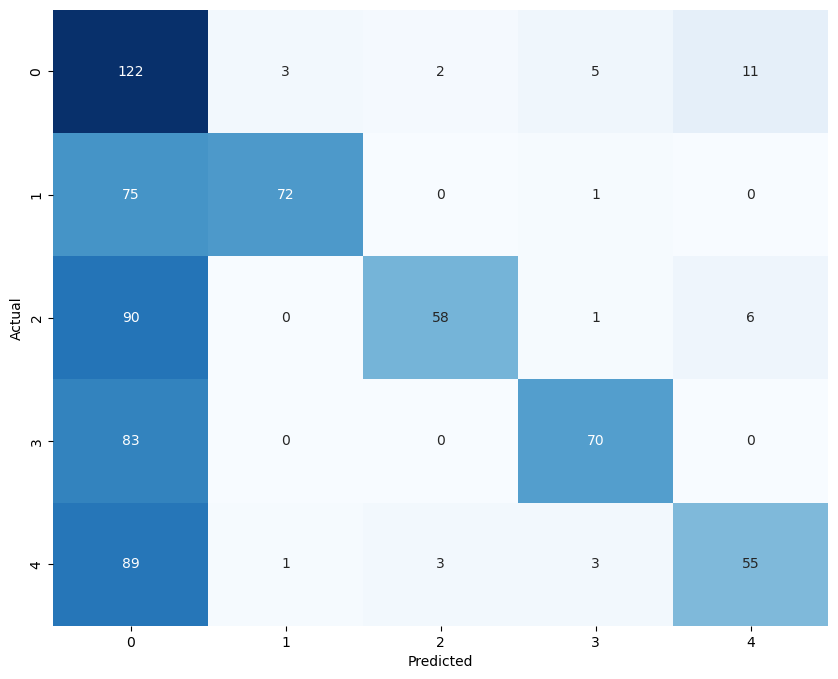

In [22]:
#import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predicted_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(test_y, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




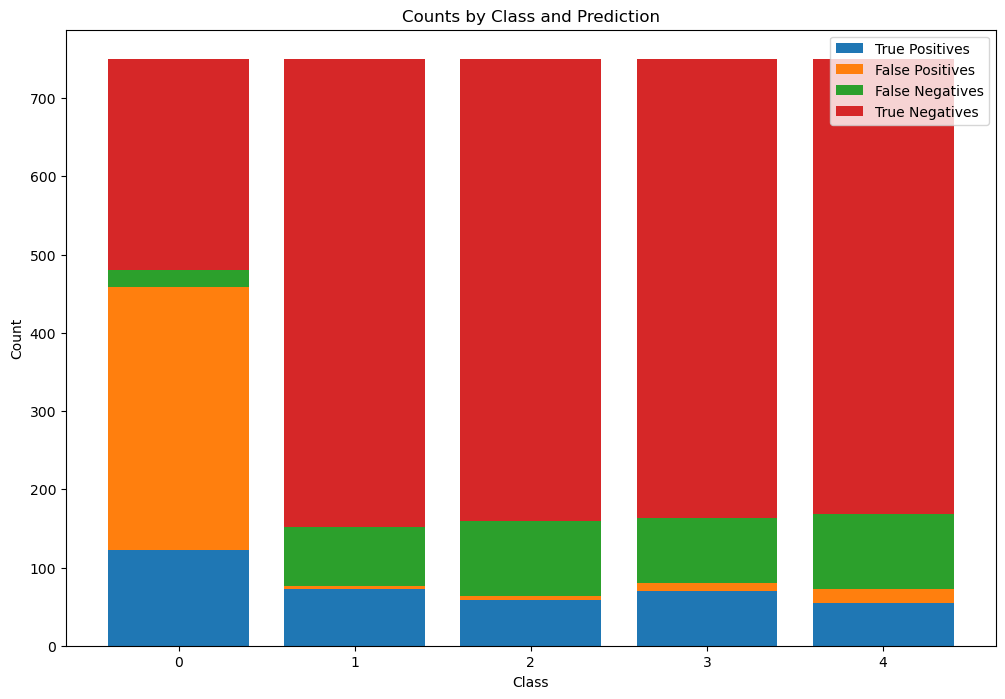

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

predicted_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(test_y, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate counts for each class
true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives
false_negatives = np.sum(conf_matrix, axis=1) - true_positives
true_negatives = np.sum(conf_matrix) - (true_positives + false_positives + false_negatives)

# Plot bar charts
classes = range(len(conf_matrix))
plt.figure(figsize=(12, 8))
plt.bar(classes, true_positives, label='True Positives')
plt.bar(classes, false_positives, bottom=true_positives, label='False Positives')
plt.bar(classes, false_negatives, bottom=true_positives+false_positives, label='False Negatives')
plt.bar(classes, true_negatives, bottom=true_positives+false_positives+false_negatives, label='True Negatives')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Counts by Class and Prediction')
plt.legend()
plt.xticks(classes)
plt.show()


In [25]:
from sklearn.metrics import accuracy_score
predicted_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(test_y, axis=1)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 50.27%


In [26]:
from sklearn.metrics import classification_report

# Assuming 'y_true' contains the true labels and 'y_pred' contains the predicted labels
report = classification_report(true_labels, predicted_labels)
print(report)


              precision    recall  f1-score   support

          77       0.27      0.85      0.41       143
          80       0.95      0.49      0.64       148
          85       0.92      0.37      0.53       155
          86       0.88      0.46      0.60       153
          91       0.76      0.36      0.49       151

    accuracy                           0.50       750
   macro avg       0.75      0.51      0.53       750
weighted avg       0.76      0.50      0.54       750



In [33]:
# #CORRECT CODE OOOOO
# %%writefile templates/index.html
# <!DOCTYPE html>
# <html lang="en">
# <head>
#     <meta charset="UTF-8">
#     <meta http-equiv="X-UA-Compatible" content="IE=edge">
#     <meta name="viewport" content="width=device-width, initial-scale=1.0">
#     <title>Image Captioning</title>
# </head>
# <style>
# body{
# background-color:lightblue;
# color:black;
# }

# h1{
#     font-size: 30px;
#     text-align: center;
    
# }
# </style>
# <body>
# <h1>IMAGE CAPTION GENERATOR</h1>
#     <form method="post" enctype="multipart/form-data">
#         {{ form.csrf_token }}
#         {{ form.files.label }}
#         {{ form.files }}
#         {{ form.submit }}
#     </form>
    
#     {% if image_filename %}
#         <h2>Uploaded Image</h2>
#         <img src="{{ url_for('static', filename=image_filename) }}" alt="Uploaded Image" width=300 heigth=300>
#     {% endif %}

#     {% if caption %}
#         <p><strong>Generated Caption:</strong> {{ caption }}</p>
#     {% endif %}
    
# </body>
# </html>


In [11]:
#ROUGH WORK 1

%%writefile templates/index.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Image Captioning</title>

    <style>
        body {
            background-color: #f0f8ff; /* Light Sky Blue */
            color: #333; /* Dark Gray */
            font-family: 'Arial', sans-serif;
            margin: 0;
            padding: 0;
            text-align: center;
        }

        header {
            background-color: #4682b4; /* Steel Blue */
            color: white;
            padding: 20px;
        }

        h1 {
            font-size: 36px;
        }

        form {
            margin: 20px auto;
            max-width: 400px;
            padding: 20px;
            background-color: #fff;
            border-radius: 8px;
            box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        }

        label {
            display: block;
            margin-bottom: 10px;
        }

        input[type="file"] {
            width: 100%;
            padding: 10px;
            margin-bottom: 20px;
            box-sizing: border-box;
        }

        button {
            background-color: #4682b4;
            color: white;
            padding: 10px 20px;
            border: none;
            border-radius: 4px;
            cursor: pointer;
        }

        button:hover {
            background-color: #346691;
        }

        .uploaded-image {
            margin-top: 20px;
        }

        p {
            font-size: 30px;
            margin-top: 20px;
        }
    </style>
</head>

<body>
    <header>
        <h1>IMAGE CAPTION GENERATOR</h1>
    </header>

    <form method="post" enctype="multipart/form-data">
        {{ form.csrf_token }}
        <label for="file">Choose an image:</label>
        {{ form.files }}
        <button type="submit">Generate Caption</button>
    </form>

    {% if image_filename %}
        <div class="uploaded-image">
            <h2>Uploaded Image</h2>
            <img src="{{ url_for('static', filename=image_filename) }}" alt="Uploaded Image" width="300" height="300">
        </div>
    {% endif %}
        
    {% if caption %}
        <p><strong>Generated Caption:</strong> {{ caption }}</p>
    {% endif %}
</body>
</html>


SyntaxError: invalid decimal literal (3527651971.py, line 25)

In [36]:
# #ROUGH WORK 2, THE ONE I AM USING
# %%writefile templates/index.html
# <!DOCTYPE html>
# <html lang="en">
# <head>
#     <meta charset="UTF-8">
#     <meta http-equiv="X-UA-Compatible" content="IE=edge">
#     <meta name="viewport" content="width=device-width, initial-scale=1.0">
#     <title>Image Captioning</title>
  
#     <style>
# body {
#             background-color: #f0f8ff; /* Light Sky Blue */
#             color: #333; /* Dark Gray */
#             font-family: 'Arial', sans-serif;
#             margin: 0;
#             padding: 0;
#             text-align: center;
#         }

#         header {
#             background-color: #4682b4; /* Steel Blue */
#             color: white;
#             padding: 20px;
#         }

#         h1 {
#             font-size: 36px;
#         }

#         form {
#             margin: 20px auto;
#             max-width: 400px;
#             padding: 20px;
#             background-color: #fff;
#             border-radius: 8px;
#             box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
#         }

#         label {
#             display: block;
#             margin-bottom: 10px;
#         }

#         input[type="file"] {
#             width: 100%;
#             padding: 10px;
#             margin-bottom: 20px;
#             box-sizing: border-box;
#         }

#         button {
#             background-color: #4682b4;
#             color: white;
#             padding: 10px 20px;
#             border: none;
#             border-radius: 4px;
#             cursor: pointer;
#         }

#         button:hover {
#             background-color: #346691;
#         }

#         .uploaded-image {
#             margin-top: 20px;
#         }

#         p {
#             font-size: 30px;
#             margin-top: 20px;
#         }

#         capture-btn {
#             background-color: #4682b4;
#             color: white;
#             padding: 10px 20px;
#             border: none;
#             border-radius: 4px;
#             cursor: pointer;
#         }

#         capture-btn:hover {
#             background-color: #346691;
#         }

#         captured-image {
#             display: none;
#             max-width: 100%;
#             margin-top: 20px;
#         }
# </style>


# </head>

# <body>
#     <header>
#         <h1>IMAGE CAPTION GENERATOR</h1>
#     </header>

#     <form id="image-form" method="post" enctype="multipart/form-data">
#         <label for="file">Choose an image:</label>
#         {{ form.files }}
#         <button type="button" id="capture-btn">Capture Image</button>
#         <input type="hidden" name="captured_image" id="captured-image-input">
#         <button type="submit">Generate Caption</button>
#         <button type="submit">Upload Image Caption</button>       
#     </form>

#     <div id="captured-image" class="uploaded-image">
#         <h2>Prediction</h2>
#         <img id="captured-image-display" alt="Captured Image" width="300" height="300">
#     </div>

#     {% if image_filename %}
#         <div class="uploaded-image">
#             <h2>Uploaded Image</h2>
#             <img src="{{ url_for('static', filename=image_filename) }}" alt="Uploaded Image" width="300" height="300">
#         </div>
#     {% endif %}
    
#     {% if caption %}
#         <p><strong>Generated Caption:</strong> {{ caption }}</p>
#     {% endif %}

#     <script>
#     document.addEventListener("DOMContentLoaded", function () {
#         const captureBtn = document.getElementById("capture-btn");
#         const capturedImageInput = document.getElementById("captured-image-input");
#         const capturedImageDisplay = document.getElementById("captured-image-display");
#         const capturedImageDiv = document.getElementById("captured-image");

#         captureBtn.addEventListener("click", function () {
#             navigator.mediaDevices.getUserMedia({ video: true })
#                 .then(function (stream) {
#                     const video = document.createElement("video");
#                     document.body.appendChild(video);
#                     video.srcObject = stream;
#                     video.play();

#                     setTimeout(function () {
#                         const canvas = document.createElement("canvas");
#                         canvas.width = video.videoWidth;
#                         canvas.height = video.videoHeight;
#                         const context = canvas.getContext("2d");
#                         context.drawImage(video, 0, 0, canvas.width, canvas.height);
#                         const capturedImageDataUrl = canvas.toDataURL("image/jpeg");
#                         capturedImageInput.value = capturedImageDataUrl;
#                         capturedImageDisplay.src = capturedImageDataUrl;
#                         capturedImageDiv.style.display = "block";

#                         stream.getTracks().forEach(track => track.stop());
#                         video.remove();
#                     }, 2000);
#                 })
#                 .catch(function (error) {
#                     console.error("Error accessing camera:", error);
#                 });
#         });
#     });
# </script>
# </body>
# </html>


SyntaxError: invalid decimal literal (379764425.py, line 24)

In [3]:
# #ROUGH WORK 2, THE ONE I AM USING

# from tensorflow.keras.applications import MobileNetV2
# import keras.backend as K
# import numpy as np
# from PIL import Image
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
# from tensorflow.keras.models import model_from_json
# from flask import Flask, render_template, request, flash, jsonify
# from flask_wtf import FlaskForm
# from wtforms import FileField, SubmitField
# from flask_wtf.file import FileRequired, FileAllowed
# from werkzeug.utils import secure_filename
# import os
# from wtforms.validators import InputRequired

# app = Flask(__name__)
# app.config['SECRET_KEY'] = 'secret'
# app.config['UPLOAD_FOLDER'] = 'static'
# #app.config['WTF_CSRF_ENABLED'] = True


# class UploadFiles(FlaskForm):
#     files = FileField("", validators=[InputRequired(), FileRequired(), FileAllowed(['jpg', 'png', 'jpeg'], 'Images only!')], render_kw={"multiple": True})
#     submit = SubmitField("Generate Caption")
    

# def get_code(my_image):      
#     convnet = MobileNetV2(input_shape=(224, 224, 3), 
#                           include_top=False, 
#                           weights='imagenet')

#     # Use the 'Conv_1' layer from MobileNetV2 to generate neural codes for the image
#     inpt = convnet.input
#     output = convnet.get_layer("Conv_1").output
#     conv_1 = K.function([inpt], [output])
#     # No need to reshape the image
#     neural_code = conv_1([my_image])[0]
#     image_code = neural_code.flatten()
#     return image_code


# def load_decoder_model():
#     with open("decoder_model.json", "r") as json_file:
#         loaded_model_json = json_file.read()
#         decoder = model_from_json(loaded_model_json)
#         decoder.load_weights("decoder_model_weights.h5")
#     return decoder

# def save_captured_image(data_url, file_path):
#     # Extract the base64 data from the data URL
#     print(f"File path: {file_path}")
#     data = data_url.split(',')[1]
#     img_data = bytes(data, 'utf-8')
#     # Save the image to the specified file path
#     with open(file_path, 'wb') as f:
#         f.write(base64.decodebytes(img_data))

# import uuid  # Import the uuid module

# @app.route('/', methods=['GET', 'POST'])
# def hello_world():
#     form = UploadFiles()
#     image_filename = None
#     caption = None

#     if form.validate_on_submit() and request.method == 'POST':
#     #if form.validate_on_submit():
#         decoder = load_decoder_model()
        
#         # Check if an image is uploaded
#         if form.files.data:
#             for file in request.files.getlist('files'):
#                 filename = secure_filename(file.filename)
#                 file_path = os.path.join(app.root_path, app.config['UPLOAD_FOLDER'], filename)
#                 file.save(file_path)
#                 flash('Image successfully uploaded and displayed below')
#                 image_filename = filename
#         else:
#             # If no file uploaded, generate a unique filename for the captured image
#             captured_image_filename = str(uuid.uuid4()) + ".jpg"
#             file_path = os.path.join(app.root_path, app.config['UPLOAD_FOLDER'], captured_image_filename)
#             image_data_url = request.form.get('captured_image')
#             save_captured_image(image_data_url, file_path)
#             flash('Image successfully captured and displayed below')
#             image_filename = captured_image_filename

#         my_image = Image.open(file_path)
#         my_image = my_image.resize((224, 224), Image.BILINEAR)
#         my_image = np.array(my_image)
#         my_image = np.expand_dims(my_image, axis=0)

#         image_code = get_code(my_image)
#         code = K.reshape(image_code, shape=(1, 62720))
#         encoded_caption = decoder(code)
#         encoded_caption = [int(K.eval(k)) for k in encoded_caption if int(K.eval(k)) > 0]
#         caption = [idx_to_word[i] for i in encoded_caption]
#         caption = ' '.join(caption)
#         print(caption)

#     return render_template('index.html', form=form, image_filename=image_filename, caption=caption)



# #     return render_template('index.html', form=form, image_filename=image_filename, caption=caption)
    




# if __name__ == '__main__':
#     app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [21/Feb/2024 23:20:46] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Feb/2024 23:20:46] "GET /favicon.ico HTTP/1.1" 404 -
[2024-02-21 23:20:58,054] ERROR in app: Exception on / [POST]
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\Lib\site-packages\flask\app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\anaconda3\Lib\site-packages\flask\app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\anaconda3\Lib\site-packages\flask\app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\anaconda3\Lib\site-packages\flask\app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^

In [ ]:
#ROUGH WORK OOOOO DO NOT MIX UP 1

from tensorflow.keras.applications import MobileNetV2
import keras.backend as K
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import model_from_json
from flask import Flask, render_template, request, flash, jsonify
from flask_wtf import FlaskForm
from wtforms import FileField, SubmitField
from flask_wtf.file import FileRequired, FileAllowed
from werkzeug.utils import secure_filename
import os
from wtforms.validators import InputRequired

app = Flask(__name__)
app.config['SECRET_KEY'] = 'secret'
app.config['UPLOAD_FOLDER'] = 'static'

class UploadFiles(FlaskForm):
    files = FileField("", validators=[InputRequired(), FileRequired(), FileAllowed(['jpg', 'png', 'jpeg'], 'Images only!')], render_kw={"multiple": True})
    submit = SubmitField("Generate Caption")
    

def get_code(my_image):      
    convnet = MobileNetV2(input_shape=(224, 224, 3), 
                          include_top=False, 
                          weights='imagenet')

    # Use the 'Conv_1' layer from MobileNetV2 to generate neural codes for the image
    inpt = convnet.input
    output = convnet.get_layer("Conv_1").output
    conv_1 = K.function([inpt], [output])
    # No need to reshape the image
    neural_code = conv_1([my_image])[0]
    image_code = neural_code.flatten()
    return image_code


def load_decoder_model():
    with open("decoder_model.json", "r") as json_file:
        loaded_model_json = json_file.read()
        decoder = model_from_json(loaded_model_json)
        decoder.load_weights("decoder_model_weights.h5")
    return decoder

@app.route('/', methods=['GET', 'POST'])
def hello_world():
    form = UploadFiles()
    image_filename = None  # Initialize with a default value
    caption = None
    
    if form.validate_on_submit():
        decoder = load_decoder_model()  # Load the decoder model
        for file in request.files.getlist('files'):
            filename = secure_filename(file.filename)
            file_path = os.path.join(app.root_path, app.config['UPLOAD_FOLDER'], filename)
            file.save(file_path)
            flash('Image successfully uploaded and displayed below')
            image_filename = filename  # Assign the filename after upload
            my_image = Image.open(file_path)
            my_image = my_image.resize((224, 224), Image.BILINEAR)  # Resize to 224x224 with bilinear interpolation
            my_image = np.array(my_image)  # Convert PIL Image to numpy array
            my_image = np.expand_dims(my_image, axis=0)  # Add batch dimension

            image_code = get_code(my_image)
            code = K.reshape(image_code, shape=(1, 62720))
            encoded_caption = decoder(code)
            encoded_caption = [int(K.eval(k)) for k in encoded_caption if int(K.eval(k)) > 0]
            caption = [idx_to_word[i] for i in encoded_caption]
            caption = ' '.join(caption)
            print(caption)


    return render_template('index.html', form=form, image_filename=image_filename, caption=caption)
    




if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [29/Feb/2024 12:19:20] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Feb/2024 13:17:55] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [29/Feb/2024 13:17:55] "GET /static/a11.jpeg HTTP/1.1" 200 -


Domestic cats, like their wild relatives (Mammalia, genus Felis), thrive in our homes, living around 12-15 years with proper care. They commonly inhabit living spaces, are not endangered, and have diverse breeds like Domestic Shorthair, Siamese, Persian, Maine Coon, Sphynx, and Bengal. Cats start having kittens at six months, and the mother cares for them until they're weaned. Despite occasional furniture scratches, their bond with humans is strong, blending mystery with affection. Their diet primarily revolves around protein.


127.0.0.1 - - [29/Feb/2024 13:20:39] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [29/Feb/2024 13:20:39] "GET /static/d35.jpg HTTP/1.1" 200 -


Dogs are of the class Mammalia and genus Canis and are adaptable from home to outdoors. Dog species are not endangered and they have a life span of 10-13 year lifespan, varying by breed. Dogs give birth to litters varying between 6 to 10. Although dogs are known for friendliness and unmatched loyalty, there are yet harmful breeds that one should be careful of. Naturally dogs are for security purpose so before you step on that lawn, before you open that gate, watch out. Dogs are omnivores as they have diverse diets.


127.0.0.1 - - [29/Feb/2024 13:22:14] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [29/Feb/2024 13:22:14] "GET /static/my_pic.jpg HTTP/1.1" 200 -


Turtles, part of the reptilian class Reptilia and order Testudines, inhabit diverse environments from oceans and rivers to forests and deserts. Threatened by habitat destruction and illegal trade, some species boast lifespans exceeding a century. Reproducing by laying eggs on land, turtles exhibit varying nesting habits. Once laid, the eggs undergo a Do-It-Yourself journey as turtles typically don't nurture their young. Generally harmless to humans, they tend to retreat into their shells rather than pose a threat. Turtles display diverse diets some herbivores, others omnivores or carnivores.


In [176]:
# #CORRECT CODE CORRECT CODE CORECT CODE OOOO!!!

# from tensorflow.keras.applications import MobileNetV2
# import keras.backend as K
# import numpy as np
# from PIL import Image
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
# from tensorflow.keras.models import model_from_json
# from flask import Flask, render_template, request, flash
# from flask_wtf import FlaskForm
# from wtforms import FileField, SubmitField
# from flask_wtf.file import FileRequired, FileAllowed
# from werkzeug.utils import secure_filename
# import os
# from wtforms.validators import InputRequired



# app = Flask(__name__)
# app.config['SECRET_KEY'] = 'secret'
# app.config['UPLOAD_FOLDER'] = 'static'

# class UploadFiles(FlaskForm):
#     files = FileField("", validators=[InputRequired(), FileRequired(), FileAllowed(['jpg', 'png', 'jpeg'], 'Images only!')], render_kw={"multiple": True})
#     submit = SubmitField("Upload Files")

# # def get_code(image):      
# #     convnet = MobileNetV2(input_shape=(224, 224, 3), 
# #                           include_top=False, 
# #                           weights='imagenet')

# #     # Use the 'Conv_1' layer from MobileNetV2 to generate neural codes for the image
# #     inpt = convnet.input
# #     output = convnet.get_layer("Conv_1").output
# #     conv_1 = K.function([inpt], [output])
# #     #image = image.reshape((1, 224, 224, 3))
# #     image = np.reshape(image, (1, 224, 224, 3))
# #     neural_code = conv_1([image])[0]
# #     image_code = neural_code.flatten()
# #     return image_code



# def get_code(my_image):      
#     convnet = MobileNetV2(input_shape=(224, 224, 3), 
#                           include_top=False, 
#                           weights='imagenet')

#     # Use the 'Conv_1' layer from MobileNetV2 to generate neural codes for the image
#     inpt = convnet.input
#     output = convnet.get_layer("Conv_1").output
#     conv_1 = K.function([inpt], [output])
#     # No need to reshape the image
#     neural_code = conv_1([my_image])[0]
#     image_code = neural_code.flatten()
#     return image_code


# def load_decoder_model():
#     with open("decoder_model.json", "r") as json_file:
#         loaded_model_json = json_file.read()
#         decoder = model_from_json(loaded_model_json)
#         decoder.load_weights("decoder_model_weights.h5")
#     return decoder

# @app.route('/', methods=['GET', 'POST'])
# def hello_world():
#     form = UploadFiles()
#     image_filename = None  # Initialize with a default value
#     caption = None
    
#     if form.validate_on_submit():
#         decoder = load_decoder_model()  # Load the decoder model
#         for file in request.files.getlist('files'):
#             filename = secure_filename(file.filename)
#             #file.save(os.path.join(app.root_path, app.config['UPLOAD_FOLDER'], filename))
#             file_path = os.path.join(app.root_path, app.config['UPLOAD_FOLDER'], filename)
#             file.save(file_path)
#             flash('Image successfully uploaded and displayed below')
#             image_filename = filename  # Assign the filename after upload
# #             img = image.load_img(file_path, target_size=(224, 224))
# #             img_array = image.img_to_array(img)
# #             image_code = get_code(image)
#             #image_code = image_code.astype(np.int32)  # Ensure the correct data type
#             my_image = Image.open(file_path)
#             my_image = my_image.resize((224, 224), Image.BILINEAR)  # Resize to 224x224 with bilinear interpolation
#             my_image = np.array(my_image)  # Convert PIL Image to numpy array
#             my_image = np.expand_dims(my_image, axis=0)  # Add batch dimension

#             image_code = get_code(my_image)
# #         # Assuming 'image_code' is the code representation of an image
#             #caption = decoder.predict(np.array([image_code]))  # Adjust input shape as needed         
          

# #             full_array = np.concatenate(caption)
# #             caption_text = full_array.astype(str).astype(np.unicode_)
# #             caption = "".join(caption_text)
#             code = K.reshape(image_code, shape=(1, 62720))

# # Generate caption using the decoder model
#             encoded_caption = decoder(code)

# # Convert the encoded caption to a list of positive integers
#             encoded_caption = [int(K.eval(k)) for k in encoded_caption if int(K.eval(k)) > 0]

# # Map indices to words using idx_to_word
#             caption = [idx_to_word[i] for i in encoded_caption]
#             caption = ' '.join(caption)

# # Print the resulting sentence without symbols
#             print(caption)
#     return render_template('index.html', form=form, image_filename=image_filename, caption=caption)
#     # return render_template('index.html', form=form, caption=caption)  # If showing the image isn't necessary

# if __name__ == '__main__':
#     app.run()


In [35]:
#HTML CODE

<!DOCTYPE html>
<html lang="en">
<head>
    <!-- Add your meta tags, title, and CSS styles -->
</head>
<body>
    <!-- Header -->
    <header>
        <h1>IMAGE CAPTION GENERATOR</h1>
    </header>

    <!-- Form for uploading images -->
    <form id="image-form" method="post" enctype="multipart/form-data">
        <label for="file">Choose an image:</label>
        {{ form.files }}
        <input type="file" name="files" id="file" multiple required>
        <button type="button" id="capture-btn">Capture Image</button>
        <input type="text" id="file-path" name="file-path" readonly>
        <button type="submit">Generate Caption</button>
        <button type="submit" formaction="/upload">Upload</button> <!-- Added Upload button -->
    </form>

    <!-- Display captured image -->
    <div id="captured-image" class="uploaded-image">
        <h2>Captured Image</h2>
        <img id="captured-image-display" alt="Captured Image" width="300" height="300">
    </div>

    <!-- Display uploaded image -->
    {% if image_filename %}
        <div class="uploaded-image">
            <h2>Uploaded Image</h2>
            <img src="{{ url_for('static', filename=image_filename) }}" alt="Uploaded Image" width="300" height="300">
        </div>
    {% endif %}

    <!-- Display generated caption -->
    {% if caption %}
        <p><strong>Generated Caption:</strong> {{ caption }}</p>
    {% endif %}

    <!-- JavaScript code to capture image and update file path -->
    <script>
    document.addEventListener("DOMContentLoaded", function () {
        const fileInput = document.getElementById("file");
        const captureBtn = document.getElementById("capture-btn");
        const capturedImageDisplay = document.getElementById("captured-image-display");
        const filePathInput = document.getElementById("file-path");

        fileInput.addEventListener("change", function () {
            filePathInput.value = this.value.split("\\").pop();
        });

        captureBtn.addEventListener("click", function () {
            // Add code to capture image
        });
    });
    </script>
</body>
</html>


SyntaxError: invalid syntax (3892533894.py, line 3)

In [39]:
#HTML CODE
%%writefile templates/index.html
<!DOCTYPE html>
<html lang="en">
<head>
    <!-- Add your meta tags, title, and CSS styles -->
</head>
<body>
    <!-- Header -->
    <header>
        <h1>IMAGE CAPTION GENERATOR</h1>
    </header>

    <!-- Form for uploading images -->
    <form id="image-form" method="post" enctype="multipart/form-data">
        <label for="file">Choose an image:</label>
        {{ form.files }}
        <input type="file" name="files" id="file" multiple required>
        <input type="text" id="file-path" name="file-path" readonly>
        <button type="submit">Generate Caption</button>
        
    </form>

        <!-- Display uploaded image -->
    {% if image_filename %}
        <div class="uploaded-image">
            <h2>Uploaded Image</h2>
            <img src="{{ url_for('static', filename=image_filename) }}" alt="Uploaded Image" width="300" height="300">
        </div>
    {% endif %}

    <!-- Display generated caption -->
    {% if caption %}
        <p><strong>Generated Caption:</strong> {{ caption }}</p>
    {% endif %}

</body>
</html>


SyntaxError: invalid syntax (541062075.py, line 3)

In [38]:
#FLASK APP CODE

from flask import Flask, render_template, request, flash, redirect, url_for
from flask_wtf import FlaskForm
from wtforms import FileField, SubmitField
from wtforms.validators import InputRequired
from werkzeug.utils import secure_filename
import os
import uuid

app = Flask(__name__)
app.config['SECRET_KEY'] = 'secret'
app.config['UPLOAD_FOLDER'] = 'static'

class UploadFiles(FlaskForm):
    files = FileField("", validators=[InputRequired()], render_kw={"multiple": True})
    submit = SubmitField("Generate Caption")

@app.route('/', methods=['GET', 'POST'])
def index():
    form = UploadFiles()
    image_filename = None
    caption = None

    if form.validate_on_submit():
        # Handle image upload
        for file in request.files.getlist('files'):
            filename = secure_filename(file.filename)
            file_path = os.path.join(app.root_path, app.config['UPLOAD_FOLDER'], filename)
            file.save(file_path)
            image_filename = filename
            flash('Image successfully uploaded')

        # Generate caption (add your caption generation code here)
            image_filename = filename  # Assign the filename after upload
            my_image = Image.open(file_path)
            my_image = my_image.resize((224, 224), Image.BILINEAR)  # Resize to 224x224 with bilinear interpolation
            my_image = np.array(my_image)  # Convert PIL Image to numpy array
            my_image = np.expand_dims(my_image, axis=0)  # Add batch dimension

            image_code = get_code(my_image)
            code = K.reshape(image_code, shape=(1, 62720))
            encoded_caption = decoder(code)
            encoded_caption = [int(K.eval(k)) for k in encoded_caption if int(K.eval(k)) > 0]
            caption = [idx_to_word[i] for i in encoded_caption]
            caption = ' '.join(caption)
            print(caption)

    return render_template('index.html', form=form, image_filename=image_filename, caption=caption)

@app.route('/upload', methods=['POST'])
def upload():
    # Handle image upload from captured image (add your capture image code here)
    captured_image_filename = str(uuid.uuid4()) + ".jpg"
    file_path = os.path.join(app.root_path, app.config['UPLOAD_FOLDER'], captured_image_filename)
    # Save captured image
    # Add code to save captured image and update file_path
    flash('Image successfully captured')
    return redirect(url_for('index'))

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (windowsapi)


SystemExit: 1

In [ ]:
#SHUFFLING CAPTIONS

# import pandas as pd

# # Get a list of image filenames in the folder
# image_filenames = os.listdir(image_folder)

# # Load your CSV file
# captions_df = pd.read_csv(r"C:\Users\HP\Desktop\Dataset\MY TRAINING CAPTIONS1.csv")

# # Shuffle the captions
# shuffled_captions_df = captions_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Save the shuffled captions to a new CSV file
# shuffled_captions_df.to_csv(r"C:\Users\HP\Desktop\Dataset\MY TRAINING CAPTIONS1.csv", index=False)


In [229]:
# #SHUFFLING IMAGES
# import os
# import random
# from shutil import move

# def shuffle_images(image_folder, shuffled_folder):
#     # Get a list of all image files in the folder
#     image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

#     # Create a list of indices corresponding to image files
#     indices = list(range(len(image_files)))

#     # Shuffle the list of indices
#     random.shuffle(indices)

#     # Create the specified folder for shuffled images if it doesn't exist
#     os.makedirs(shuffled_folder, exist_ok=True)

#     # Iterate over the shuffled indices and move images to the new folder
#     for i, index in enumerate(indices):
#         original_filename = image_files[index]
#         original_path = os.path.join(image_folder, original_filename)

#         # Prefix each image with 'shuffled_' and a number
#         new_filename = f"{i + 3601}_{original_filename}"
#         new_path = os.path.join(shuffled_folder, new_filename)

#         # Move the image file
#         move(original_path, new_path)

#     print(f"Images shuffled and saved in: {shuffled_folder}")

# # Replace 'path_to_your_images_folder' and 'path_to_your_shuffled_folder' with the actual paths
# image_folder = r'C:\Users\HP\Desktop\Dataset\test images'
# shuffled_folder = r'C:\Users\HP\Desktop\Dataset\shuffled_images'

# shuffle_images(image_folder, shuffled_folder)


Images shuffled and saved in: C:\Users\HP\Desktop\Dataset\shuffled_images
